In [4]:
#some imports

import numpy as np
from numpy import random
from numpy import linalg
import matplotlib.pyplot as plt

random.seed(0)

In [23]:
#This function plots the contourline func(x) = value
def plot_contour_line(func, value=0, x_values=np.empty(0)):
    
    minx = -1
    maxx = 2
    miny = -1
    maxy = 2
    
    #print(np.array(x_values.shape))
    if (np.array(x_values.shape)[1] ==2):
        x_values = x_values.T
    
    # sets minx, etc. if x_values is a two-dimensoinal array of values
    if np.array(x_values.shape).shape[0] > 1:
        dim = np.array(x_values.shape)[0]
        if dim==2:
            minx = ((int)(np.amin(x_values[0])))-1.5
            maxx = ((int)(np.amax(x_values[0])))+1.5
            miny = ((int)(np.amin(x_values[1])))-1.5
            maxy = ((int)(np.amax(x_values[1])))+1.5
    samplenum = 100
    xrange = np.arange(minx, maxx, (maxx-minx)/samplenum)
    yrange = np.arange(miny, maxy, (maxy-miny)/samplenum)
    
    #This generates a two-dimensional mesh
    X, Y = np.meshgrid(xrange,yrange)
    # print(X,Y)
    
    argsForf = np.array([X.flatten(),Y.flatten()]).T
    Z = func(argsForf)
    Z = np.reshape(Z,X.shape)
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.contour(X, Y, Z, alpha=0.5,levels=[value],linestyles='dashed',linewidths=3)
    Z = np.where(Z > value, 1, -1)
    plt.contourf(X, Y, Z, alpha=0.2, cmap=plt.cm.coolwarm)

-------------------------------------------
## Task 2.1


In [4]:
def one_step(beta, y, x, b, n, i, j, C):
    """beta: (n); y: (n); x: (n, d); b, n, i, j, C scalar"""
    #beta_old = np.zeros(0, n)
    #beta_old[j] = beta[j]
    #beta_old[i] = beta[i]
    
    f = lambda xk: np.multiply(beta.T, y) @ (x @ xk) + b
    delta = y[i]*((f(x[j])-y[j]) - (f(x[i])-y[i]))
    s = y[i] * y[j]
    chi = x[i] @ x[i] + x[j] @ x[j] - 2 * (x[i] @ x[j])
    gamma = s*beta[i] + beta[j]
    if s==1:
        if gamma - C > 0:
            L = gamma - C
            H = C
        else:
            L = 0
            H = gamma
    else:
        if gamma > 0:
            L = 0
            H = C - gamma
        else:
            L = -gamma
            H = C
    if chi > 0:
        if beta[i] + delta / chi > L:
            if beta[i] + delta / chi > H:
                beta[i] = H
            else:
                beta[i] = beta[i] + delta / chi
        else:
            if L > H:
                beta[i] = H
            else:
                beta[i] = L
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
    beta[j] = gamma - s*beta[i]
    f = lambda xk: np.multiply(beta.T, y) @ (x @ xk) + b
    b = b - 1/2*(f(x[i]) - y[i] + f(x[j]) - y[j])
    return b, beta

-------------------------------------------------
## Task 2.2

In [5]:
def create_test_data(d = 2, n = 40, lambda_1 = 4, lambda_2 = 0.5, lable_1 = -1, lable_2 = 1):
    x_group_1 = np.random.exponential(1/lambda_1, (int)(n/2 * d)).reshape(((int)(n/2), d))
    x_group_2 = np.random.exponential(1/lambda_2, (int)(n/2 * d)).reshape(((int)(n/2), d))
    x = np.vstack((x_group_1, x_group_2))
    y = np.hstack((np.full((int)(n/2), lable_1), np.full((int)(n/2), lable_2)))
    return x, y

------------------------------------------
## Task 2.3

Initialize beta and b with 0 and work with one_step function.

In [6]:
def sequential_minimal_optimization(x, y, C, iterations = 10000, n=40, d=2):
    """optimize the classification with SMO. 
    Enter x_k values in x of shape (n, d), y values of shape (n). C>0 is the regularization."""
    ## task a
    b = 0
    beta = np.zeros(n)
    
    for k in np.arange(0, iterations):
        i = np.random.randint(0, n)
        j = np.random.randint(0, n-1)
        if j>=i:
            j += 1
        b, beta = one_step(beta, y, x, b, n, i, j, C)
        
    ## task b
    f = lambda xk: np.multiply(beta.T, y) @ (x @ xk.T) + b
    med = np.median(np.subtract(f(x[beta>0]), y[beta>0]))
    b -= med
    f = lambda xk: np.multiply(beta.T, y) @ (x @ xk.T) + b
    return f, beta

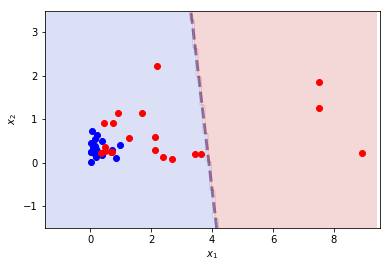

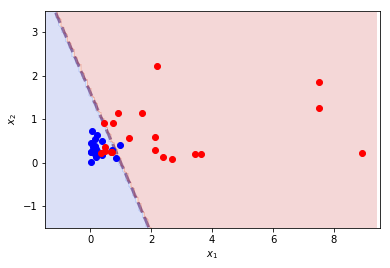

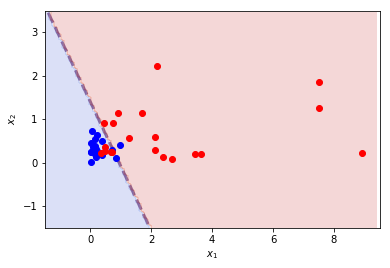

In [7]:
x, y = create_test_data()
for C in (0.01, 1, 100):
    f, beta = sequential_minimal_optimization(x, y, C)
    plt.plot(x[:20,0], x[:20,1], 'bo')
    plt.plot(x[20:,0], x[20:,1], 'ro')
    plot_contour_line(f, 0, x)
    plt.show()

In [8]:
# task c + d
def get_support_and_margin_defining_verctors(x, beta, C, n):
        is_support_vector = beta>0
        is_margin_defining_vector = np.logical_and(is_support_vector, C>beta)
        return x[is_support_vector], x[is_margin_defining_vector]

C: 0.01
38 support vectors
2 margin defining vectors


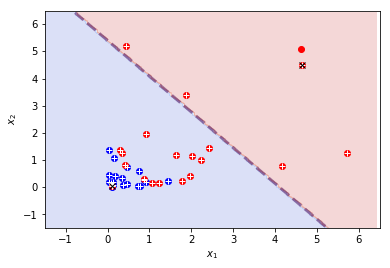

C: 1
19 support vectors
3 margin defining vectors


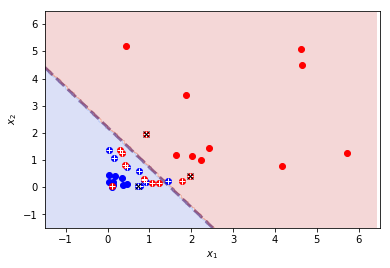

C: 100
18 support vectors
5 margin defining vectors


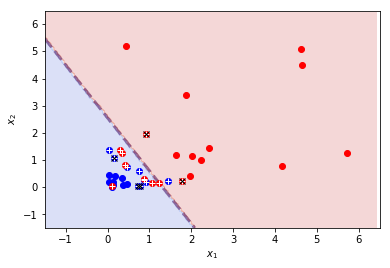

In [9]:
x, y = create_test_data()
#x = np.hstack((np.linspace(0, 1-1/20, 20).reshape(20, 1), np.zeros(20).reshape(20, 1)))
#x = np.vstack((x, np.hstack((np.linspace(1/20, 1, 20).reshape(20, 1), np.zeros(20).reshape(20, 1)))))
#y = np.append(np.full(20, 1), np.full(20, -1))
for C in (0.01, 1, 100):
    f, beta = sequential_minimal_optimization(x, y, C)
    sup_vec, marg_vec = get_support_and_margin_defining_verctors(x, beta, C, 40)
    print("C: " + str(C))
    print(str(sup_vec.shape[0]) + " support vectors")
    print(str(marg_vec.shape[0]) + " margin defining vectors")
    plt.plot(x[:20,0], x[:20,1], 'bo')
    plt.plot(x[20:,0], x[20:,1], 'ro')
    plt.plot(sup_vec[:,0], sup_vec[:,1], 'w+')
    plt.plot(marg_vec[:,0], marg_vec[:,1], 'kx')
    plot_contour_line(f, 0, x)
    plt.show()

--------------
## Task 2.4

In [10]:
# copies from sheet 1
def generate_LLS_model(x,y):
    """Returns a linear function R^d->R which oprimizes the LLS problem"""
    
    #reorganize the data in a matrix with the first row being (1,...,1)^T
    X_hat = np.asmatrix(np.hstack((np.ones((x.shape[0],1)),x)))

    #solve for the best alpha which mimimines ||X_hat * alpha - y||^2
    alpha = np.linalg.solve(X_hat.T @ X_hat, X_hat.T @ np.asmatrix(y).T)
    
    #implements the linear function based on the previously generated alpha
    f = lambda z: alpha[0,0] + z @ alpha[1:,0]
    
    return f

def confusion_matrix(x,y,f, val=0.5):
    """his calculates the confusion matrix for classes 0 and 1"""
    
    if x.shape[0] != y.shape[0]: 
        return None
    
    fx = f(x)>=0.5
    
    #we interpret the boolean values [data xi classified as 0, being 1 etc] as 1 and 0.
    #then we use matrix multiplication to count how they are distributed.
    c =  (np.asmatrix(np.vstack((y,np.logical_not(y)))) @ np.asmatrix(np.hstack((fx,np.logical_not(fx))))).T
    
    
    acc = np.trace(c)/x.shape[0]
    

    return c, acc

In [14]:
x, y = create_test_data(d = 2, n = 2000)
f_LLS = generate_LLS_model(x,y)
for C in (0.01, 1, 100):
    f_SMO, beta = sequential_minimal_optimization(x, y, C, iterations = 10000, n=2000, d=2)
    print("--------------------------")
    print("C: " + str(C))
    print()
    print("LLS model:")
    matrix, accuracy = confusion_matrix(x,y,f_LLS)
    print("accuracy: " + str(accuracy))
    #print(matrix)
    print("SMO model:")
    accuracy = (np.sum(np.logical_and(y==1, f_SMO(x)>0))+np.sum(np.logical_and(y==-1, f_SMO(x)<0)))/2000
    print("accuracy: " + str(accuracy))
    print()
    
    """argsForf = np.array([X.flatten(),Y.flatten()]).T
    Z = func(argsForf)
    Z = np.reshape(Z,X.shape)
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.contour(X, Y, Z, alpha=0.5,levels=[value],linestyles='dashed',linewidths=3)
    Z = np.where(Z > value, 1, -1)"""

--------------------------
C: 0.01

LLS model:
accuracy: 0.186
SMO model:
accuracy: 0.915

--------------------------
C: 1

LLS model:
accuracy: 0.186
SMO model:
accuracy: 0.9045

--------------------------
C: 100

LLS model:
accuracy: 0.186
SMO model:
accuracy: 0.899



-------------------------------------------
-------------------------------------------
# The kernel trick
-------------------------------------------
-------------------------------------------


In [15]:
#some imports

#import numpy as np
#from numpy import random
#from numpy import linalg
#import matplotlib.pyplot as plt
#import cmath

random.seed(0)

----------------
## Task 2.6

In [25]:
def generate_data(n = 100, radius_1 = 1, radius_2 = 2, lable_1 = -1, lable_2 = 1):
    alpha = np.random.uniform(0, 2 * np.pi, n)
    r1 = np.random.uniform(0, radius_1, (int)(n/2))
    r2 = np.random.uniform(radius_1, radius_2, (int)(n/2))
    x_val1 = r1 * np.exp(alpha[: (int)(n/2)] * 1j)
    x_val2 = r2 * np.exp(alpha[(int)(n/2):] * 1j)
    y = np.hstack((np.full((int)(n/2), lable_1), np.full((int)(n/2), lable_2)))
    return np.hstack((x_val1, x_val2)), y

In [26]:
def plot_generated_data():
    plt.plot(x[:50,0], x[:50,1], 'bo')
    plt.plot(x[50:,0], x[50:,1], 'ro')
    #return x, y

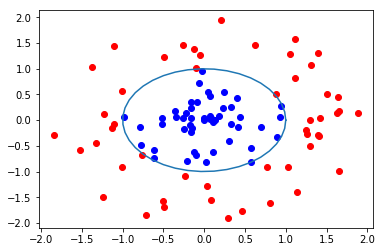

In [31]:
x, y = generate_data()
x = np.hstack((x.real.reshape(100, 1), x.imag.reshape(100, 1)))
plot_generated_data()
lin = np.linspace(0,2*np.pi, 40)
sphere = np.exp(lin*1j)
plt.plot(sphere.real, sphere.imag)

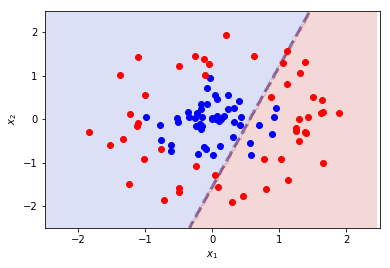

In [32]:
# task a

plot_generated_data()
f_1, beta = sequential_minimal_optimization(x, y, C = 10, iterations = 10000, n=100, d=2)
plot_contour_line(f_1, 0, x)

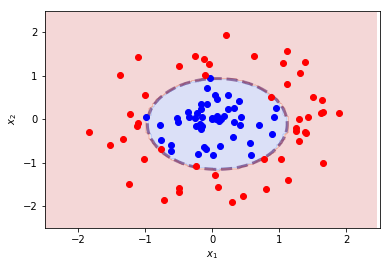

In [33]:
# task b
x_old = x
plot_generated_data()
x = np.hstack((x_old[:,0].reshape(100, 1), x_old[:,1].reshape(100, 1), (np.multiply(x_old[:,0],x_old[:,0]) + np.multiply(x_old[:,1],x_old[:,1])).reshape(100, 1)))
f_2, beta = sequential_minimal_optimization(x, y, C = 10, iterations = 10000, n=100, d=3)
f_projection = lambda z: f_2(np.vstack((z[:,0], z[:,1] ,z[:,0]*z[:,0]+z[:,1]*z[:,1])).T)
plot_contour_line(f_projection, 0, x_old)

---------------------------
# Task 2.7

Redefining the SMO

In [97]:
#some imports

import numpy as np
from numpy import random
from numpy import linalg
import matplotlib.pyplot as plt

random.seed(0)

In [98]:
#This function plots the contourline func(x) = value
def plot_contour_line(func, value=0, x_values=np.empty(0)):
    
    minx = -1
    maxx = 2
    miny = -1
    maxy = 2
    
    #print(np.array(x_values.shape))
    if (np.array(x_values.shape)[1] ==2):
        x_values = x_values.T
    
    # sets minx, etc. if x_values is a two-dimensoinal array of values
    if np.array(x_values.shape).shape[0] > 1:
        dim = np.array(x_values.shape)[0]
        if dim==2:
            minx = ((int)(np.amin(x_values[0])))-1.5
            maxx = ((int)(np.amax(x_values[0])))+1.5
            miny = ((int)(np.amin(x_values[1])))-1.5
            maxy = ((int)(np.amax(x_values[1])))+1.5
    samplenum = 100
    xrange = np.arange(minx, maxx, (maxx-minx)/samplenum)
    yrange = np.arange(miny, maxy, (maxy-miny)/samplenum)
    
    #This generates a two-dimensional mesh
    X, Y = np.meshgrid(xrange,yrange)
    # print(X,Y)
    print("shape X: ", X.shape)
    
    argsForf = np.array([X.flatten(),Y.flatten()]).T
    #Z = func(argsForf)
    print("shape ARG: ", argsForf.shape)
    Z = np.apply_along_axis(func, 1, argsForf)
    print(func(argsForf[0]))
    print("shape Z: ", Z.shape)
    print("shape X: ", X.shape)
    Z = np.reshape(Z,X.shape)
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.contour(X, Y, Z, alpha=0.5,levels=[value],linestyles='dashed',linewidths=3)
    Z = np.where(Z > value, 1, -1)
    plt.contourf(X, Y, Z, alpha=0.2, cmap=plt.cm.coolwarm)

In [99]:
def one_step_kernel(beta, y, x, b, n, i, j, C, kernel):
    """beta: (n); y: (n); x: (n, d); b, n, i, j, C scalar"""
    #beta_old = np.zeros(0, n)
    #beta_old[j] = beta[j]
    #beta_old[i] = beta[i]
    
    f = lambda xk: np.multiply(beta.T, y) @ kernel(x, xk) + b
    delta = y[i]*((f(x[j])-y[j]) - (f(x[i])-y[i]))
    s = y[i] * y[j]
    chi = kernel(x[i], x[i]) + kernel(x[j], x[j]) - 2 * kernel(x[i], x[j])
    gamma = s*beta[i] + beta[j]
    if s==1:
        if gamma - C > 0:
            L = gamma - C
            H = C
        else:
            L = 0
            H = gamma
    else:
        if gamma > 0:
            L = 0
            H = C - gamma
        else:
            L = -gamma
            H = C
    if chi > 0:
        if beta[i] + delta / chi > L:
            if beta[i] + delta / chi > H:
                beta[i] = H
            else:
                beta[i] = beta[i] + delta / chi
        else:
            if L > H:
                beta[i] = H
            else:
                beta[i] = L
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
    beta[j] = gamma - s*beta[i]
    f = lambda xk: np.multiply(beta.T, y) @ kernel(x, xk) + b
    b = b - 1/2*(f(x[i]) - y[i] + f(x[j]) - y[j])
    return b, beta

def sequential_minimal_optimization_kernel(x, y, C, kernel, iterations = 10000, n=40, d=2):
    """optimize the classification with SMO. 
    Enter x_k values in x of shape (n, d), y values of shape (n). C>0 is the regularization."""
    ## task a
    b = 0
    beta = np.zeros(n)
    
    for k in np.arange(0, iterations):
        i = np.random.randint(0, n)
        j = np.random.randint(0, n-1)
        if j>=i:
            j += 1
        b, beta = one_step_kernel(beta, y, x, b, n, i, j, C, kernel)
        
    ## task b
    f = lambda xk: np.multiply(beta.T, y) @ kernel(x, xk) + b
    #med = np.median(np.subtract(f(x[beta>0]), y[beta>0]))
    med = np.median(np.subtract(np.apply_along_axis(f, 1, x[beta>0]), y[beta>0]))
    b -= med
    f = lambda xk: np.multiply(beta.T, y) @ kernel(x, xk) + b
    return f, beta

In [100]:
def generate_data(n = 100, radius_1 = 1, radius_2 = 2, lable_1 = -1, lable_2 = 1):
    alpha = np.random.uniform(0, 2 * np.pi, n)
    r1 = np.random.uniform(0, radius_1, (int)(n/2))
    r2 = np.random.uniform(radius_1, radius_2, (int)(n/2))
    x_val1 = r1 * np.exp(alpha[: (int)(n/2)] * 1j)
    x_val2 = r2 * np.exp(alpha[(int)(n/2):] * 1j)
    y = np.hstack((np.full((int)(n/2), lable_1), np.full((int)(n/2), lable_2)))
    return np.hstack((x_val1, x_val2)), y

def plot_generated_data():
    plt.plot(x[:50,0], x[:50,1], 'bo')
    plt.plot(x[50:,0], x[50:,1], 'ro')
    #return x, y

In [101]:
# Gaussian Kernel
def get_gaussian_kernel(sigma = 1):
    return lambda t, x : np.exp(-linalg.norm(np.subtract(t,x))/(2*sigma)) if t.ndim == 1 else np.apply_along_axis(linalg.norm, 1 ,np.subtract(t,x)/(2*sigma))

shape X:  (100, 100)
shape ARG:  (10000, 2)
111.05043213655654
shape Z:  (10000,)
shape X:  (100, 100)


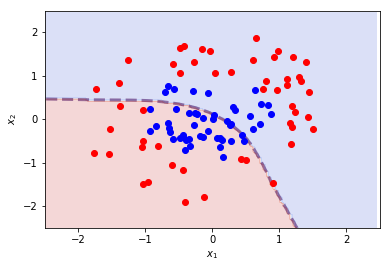

In [102]:
x, y = generate_data()
x = np.hstack((x.real.reshape(100, 1), x.imag.reshape(100, 1)))
plot_generated_data()
f_3, beta = sequential_minimal_optimization_kernel(x, y, 10, get_gaussian_kernel(),iterations = 10000, n=100, d=3)
plot_contour_line(f_3, 0, x)